# Cats versus Dogs
Exploring optimization impact on size, performance and accuracy!

**For best performance on this Colab make sure you are using a GPU runtime!** The runtime can be changed by selecting: ```runtime -> change runtime type``` and selecting GPU from the hardware accelerator dropdown.

### We start by importing TensorFlow and our Dataset
And splitting our dataset into batches.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# format images to have normalized pixels
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

# load in our dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# display how much data we have
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print(num_examples)
print(num_classes)

# split the data in training, validation, and test datasets
BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

# display the shape of our data
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteP0662O/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
23262
2


TensorShape([32, 224, 224, 3])

### We next define our (pre-trained) model

In [3]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### We then train and save our model
Since we are doing transfer learning to fine tune a pre-trained model to our dataset we only need to use 5 Epochs. We will explore transfer learning in detail and study how, why, and where it works later in this course!

In [4]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 45s 55ms/step - loss: 0.0632 - accuracy: 0.9783 - val_loss: 0.0443 - val_accuracy: 0.9858
Epoch 2/5
582/582 [==============================] - 38s 56ms/step - loss: 0.0303 - accuracy: 0.9895 - val_loss: 0.0382 - val_accuracy: 0.9875
Epoch 3/5
582/582 [==============================] - 37s 53ms/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.0375 - val_accuracy: 0.9884
Epoch 4/5
582/582 [==============================] - 35s 51ms/step - loss: 0.0226 - accuracy: 0.9924 - val_loss: 0.0542 - val_accuracy: 0.9837
Epoch 5/5
582/582 [==============================] - 37s 56ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0393 - val_accuracy: 0.9888


In [5]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)


### Your task starts here:
+ Run this code, and you'll have model1.tflite, with no optimization or quantization

+ Then, remove the comment on the ```converter.optimizations = []``` line. Change the model name to model2.tflite, and rerun. Model2.tflite will now have optimizations added -- you should see a much smaller file size.

+ Finally, remove the comments on the code to add a representative dataset and set the supported ops as shown. Change the model name to model3.tflite, and rerun. Model3.tflite will now have optimizations added, along with quantization from the representative dataset. Note: it might be slightly larger than model2.tflite!

**Note:** tf.lite.Optimize has changed and the OPTIMIZE_FOR_SIZE and OPTIMIZE_FOR_LATENCY options are now deprecated and are the same and DEFAULT: https://www.tensorflow.org/api_docs/python/tf/lite/Optimize

In [17]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

# These options are for converter optimizaitons
# Consider trying the converter without them and
# explore model size and accuracy
# Then...use them and reconvert the model and explore model
# size an accuracy at that point. What differences do you see?

converter.optimizations = [tf.lite.Optimize.DEFAULT]    # Uncomment this line for Model 2 and Model 3

# def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
#     for input_value, _ in test_batches.take(100):
#         yield [input_value]
# converter.representative_dataset = representative_data_gen()
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Define the representative data generator function
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

# Set the representative dataset for quantization
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Convert the model
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir / 'model3.tflite'  # Change the filename here for Model2 and Model3!
tflite_model_file.write_bytes(tflite_model)

#tflite_model = converter.convert()
#tflite_models_dir = pathlib.Path("/tmp/")

#tflite_model_file = tflite_models_dir/'model3.tflite'     # Change the filename here for Model2 and Model3!
#tflite_model_file.write_bytes(tflite_model)


# Without any optimizations I got
# 8857848  (model1.tflite)
# With the .optimizations property set I got
# 2629648 (model2.tflite)
# With the .optimizations property and representative data set I got
# 2835952 -- Slightly larger!  (model3.tflite)

2713024

### Your task continues
Now we will test the accuracy of the three models! After you run each model you will get the number of correct predictions and then you can plot which images were correct/incorrect!
+ Run this code
+ Change the model file to model2.tflite and run it again
+ Change the model file to model3.tflite and run it again

In [20]:
#@title Run this cell each time to test your model's accuracy (make sure to change the filename)
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = '/tmp/model3.tflite'                 # Change the filename here for Model 2 and 3
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# For model 1, I got 32.25 it/s
# For model 2, I got 16.16 it/s
# For model 3, I got 1.19s it/s
# Note: since the it/s will depend on the computer on which your Colab VM
#       instance is running -- we would expect it to vary a bit.
# Note2: Changes have been made to the TFLite Interpreter since Laurence filmed the
#        previous video that further optimize it for mobile use at the expense of
#        speed in Colab. As such, you'll find that while Laurence was able to achieve
#        16 it/s for model 2, you may only see speeds of 1-2 it/s

score = 0
for item in range(0,100):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

# Model 1 - 100 Correct
# Model 2 - 99 Correct
# Model 3 - 99 Correct
# Note: since training starts from a random intialization it would not be
#       surprising if your result is off by 1 or 2 correct.

100%|██████████| 100/100 [00:02<00:00, 34.65it/s]

Out of 100 predictions I got 100 correct


In [21]:
#@title Define utility functions once for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

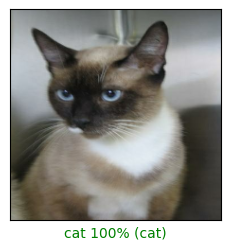

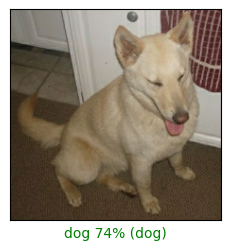

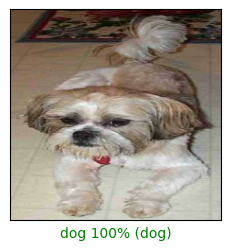

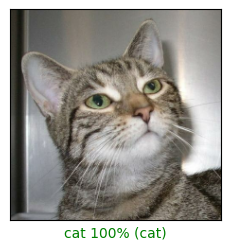

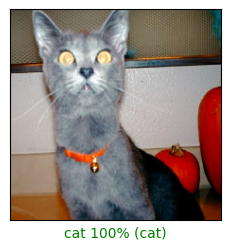

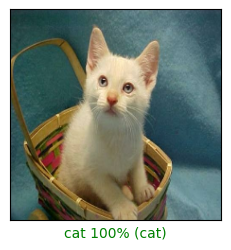

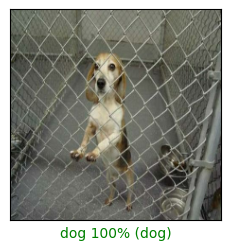

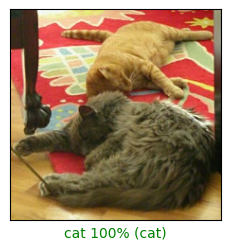

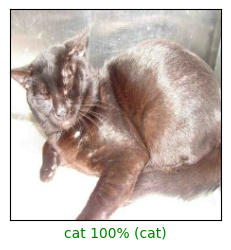

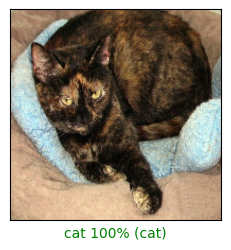

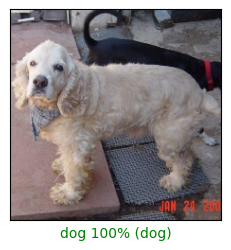

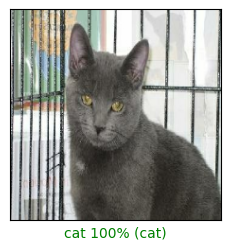

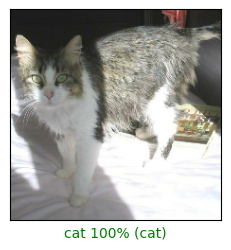

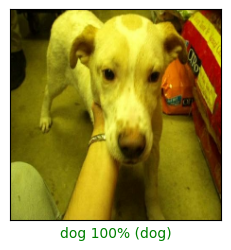

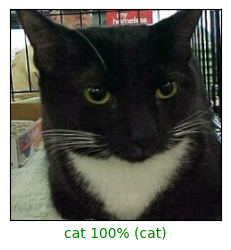

In [22]:
#@title Visualize the outputs each time { run: "auto" }
max_index = 15 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()